In [5]:
import pylift
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import causalml.metrics as cmetrics

import scipy.stats as sts

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
# pip install pylift

In [6]:
# pip install causalml

In [111]:
poor = pd.read_csv('./output_data/restored_poor_people.csv')
features = pd.read_csv('./output_data/final_dfdiouuy.csv')

In [18]:
data_rich = features.drop(columns = ['transaction_date']).query('city_type == 1').groupby('client_id').mean()
data_rich.drop(columns = ['city_type'], inplace = True)

**размечаем людей на бины: люди, у которых средний чек больше общего среднего чека, получают 1 (лит энерджи тебе или 2 другому?)**

In [50]:
data_rich['mean_up'] = np.where(data_rich.purchase_sum > data_rich.purchase_sum.mean(), 1, 0)

In [87]:
poor_data = features.drop(columns = ['transaction_date']).query('city_type == 0').groupby('client_id', as_index=False).mean()

In [114]:
poor_data = poor_data[['client_id', 'purchase_sum']].merge(poor, on = 'client_id', how = 'inner')

In [23]:
fit_index, val_index = train_test_split(data_rich.index, test_size=0.5, random_state=148)

In [28]:
column_set_n1 = ['age', 'female', 'male', 'avg_product_quantity', 'total_products',
       'ch_avg_purchase', 'unique_segments', 'unique_brands',
       'alcohol_percentage', 'own_trademark_percentage']

**фит предиктим**

In [53]:
upmodel_n0 = pylift.TransformedOutcome(
    data_rich.loc[fit_index, column_set_n1 + ['mean_up', 'treatment_flg']],
    col_treatment='treatment_flg', col_outcome='mean_up',
    test_size=2
)

In [54]:
upmodel_n0.fit()

/usr/local/lib/python3.10/dist-packages/pylift/eval.py:474: RuntimeWarning: invalid value encountered in scalar divide
  scores['q1_qini'] = scores['Q_qini']/scores['Q_max']
/usr/local/lib/python3.10/dist-packages/pylift/eval.py:475: RuntimeWarning: invalid value encountered in scalar divide
  scores['q2_qini'] = scores['Q_qini']/scores['Q_practical_max']
/usr/local/lib/python3.10/dist-packages/pylift/eval.py:479: RuntimeWarning: invalid value encountered in scalar divide
  scores['q1_cgains'] = scores['Q_cgains']/scores['Q_max']
/usr/local/lib/python3.10/dist-packages/pylift/eval.py:480: RuntimeWarning: invalid value encountered in scalar divide
  scores['q2_cgains'] = scores['Q_cgains']/scores['Q_practical_max']
/usr/local/lib/python3.10/dist-packages/pylift/eval.py:484: RuntimeWarning: invalid value encountered in scalar divide
  scores['q1_aqini'] = scores['Q_aqini']/scores['Q_max']
/usr/local/lib/python3.10/dist-packages/pylift/eval.py:485: RuntimeWarning: invalid value encountere

In [55]:
eval_data = data_rich.loc[val_index, column_set_n1 + ['mean_up', 'treatment_flg']]
eval_data['score'] = upmodel_n0.model.predict(eval_data[column_set_n1])
eval_data = eval_data[['score', 'treatment_flg', 'mean_up']]

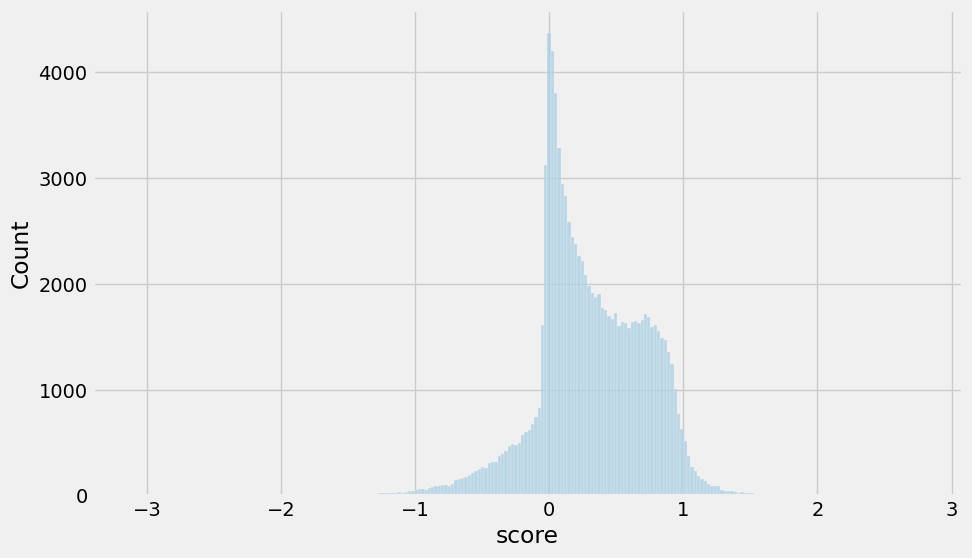

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

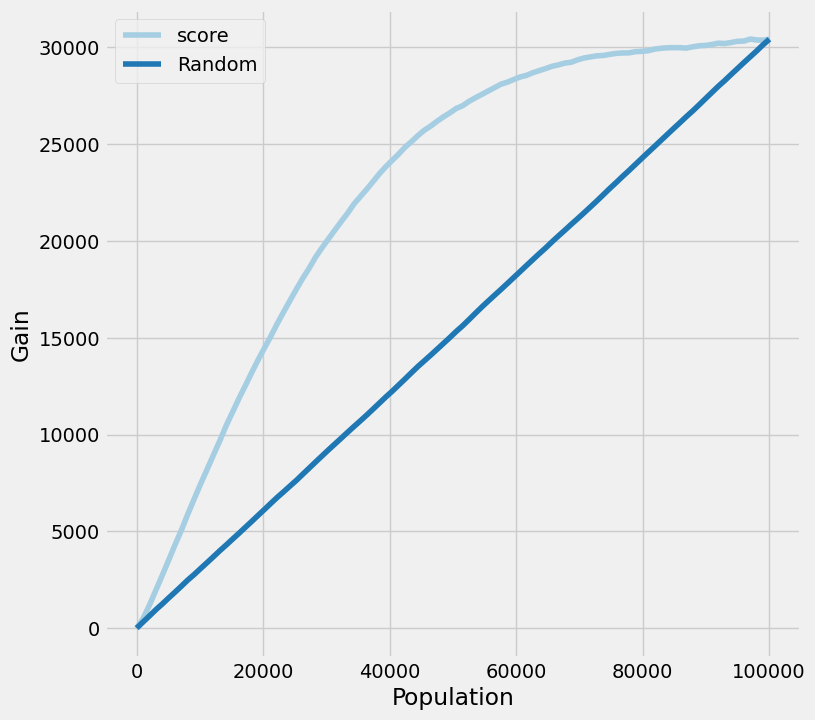

In [57]:
cmetrics.plot_gain(
    eval_data,
    treatment_col='treatment_flg',
    outcome_col='mean_up',
)

**бедный город**

In [121]:
poor_data['treatment_flg'] = 1
poor_data['treatment_flg'].loc[(poor_data.sample(len(poor_data)//2).index)] = 0
poor_data['mean_up'] = np.where(poor_data.purchase_sum > poor_data.purchase_sum.mean(), 1, 0)

<ipython-input-121-9b1354153f65>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  poor_data['treatment_flg'].loc[(poor_data.sample(len(poor_data)//2).index)] = 0
<ipython-input-121-9b1354153f65>:2: SettingWithCopyWarning: 
A value is trying 

In [115]:
poor_data['score'] = upmodel_n0.model.predict(poor_data[column_set_n1])

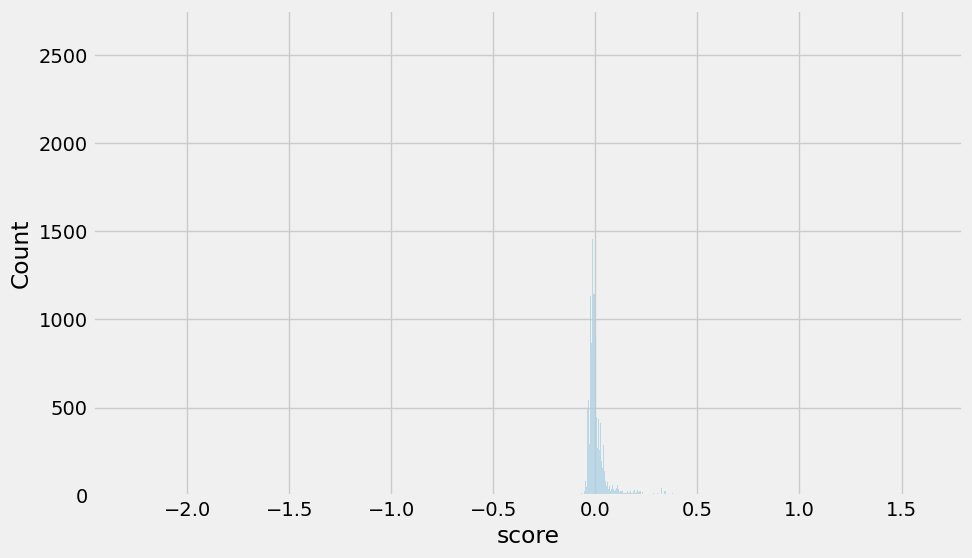

In [118]:
plt.figure(figsize=(10, 6))
sns.histplot(poor_data['score'])
plt.show()

In [122]:
poor_eval = poor_data[['score', 'treatment_flg', 'mean_up']]

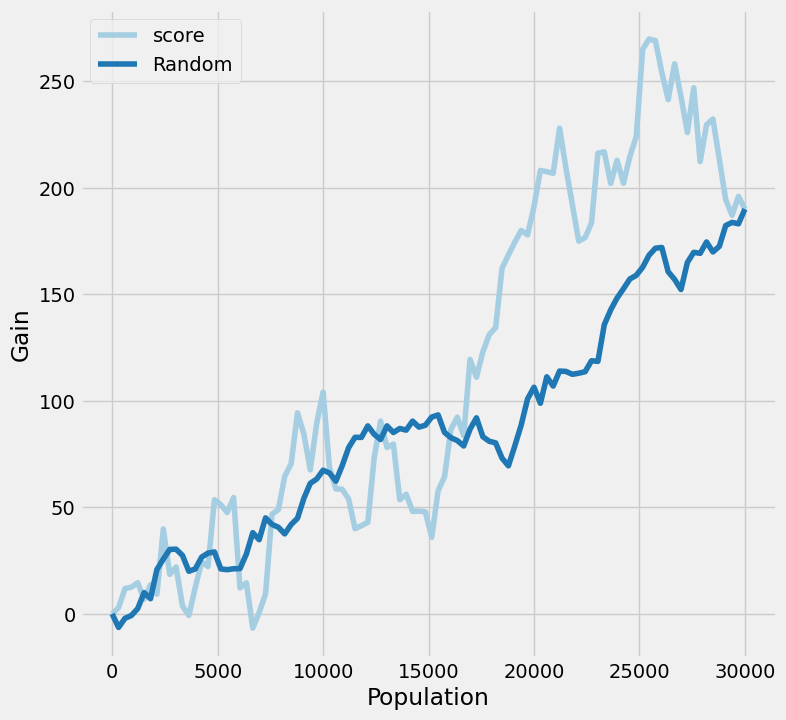

In [123]:
cmetrics.plot_gain(
    poor_eval,
    treatment_col='treatment_flg',
    outcome_col='mean_up',
)